In [ ]:
# we need the following libraries, so let's install them
%pip install matplotlib
%pip install scikit-learn
%pip install tensorflow

In [1]:
# importing libraries
from time import time
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from glob import glob
import skimage
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.gaussian_process.kernels import RBF
import sys
import warnings
from sklearn.utils import shuffle
import random
import logging
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=DeprecationWarning)
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# loadnig the data and removing the useless column 'Unnamed: 0'
whole_data = pd.read_csv('/content/gdrive/MyDrive/radiomics/MIMIC_synced_data_nan_free_.csv')
whole_data.head(5)

,Unnamed: 0,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,0,-872.712177,-30.834509,1.183500e+10,5.213223,484.245094,2.123297,127.427505,259.288179,-535.029395,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,-860.588226,-94.596062,1.748392e+10,5.468412,406.884354,2.973349,455.105927,238.126282,-510.922325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,-771.608655,246.313766,1.054451e+10,5.639891,569.798054,2.284384,601.678467,308.126190,-357.526186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,-918.119244,197.538876,1.041507e+10,5.650920,757.435298,1.774919,477.192200,369.400809,-432.636913,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,4,-809.137268,336.588287,1.613116e+10,5.824157,562.000023,2.493775,658.329407,330.944854,-337.573971,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [6]:
# excludiung Ages with Nans
whole_data = whole_data[~pd.isnull(whole_data['Age'])]
whole_data.shape

(224444, 492)

In [7]:
random_seed = 21202
del whole_data['Unnamed: 0']
whole_data.head()
whole_data = whole_data.sample(frac=1.0, random_state=random_seed)

In [8]:
# finding total number of samples:
n_samples = whole_data.shape[0]
print("number of samples are: {}".format(n_samples))

number of samples are: 224444


In [9]:
# names of all targets:
targets_names = list(whole_data.iloc[:,464:])
print(targets_names)

['index', 'path', 'subject_id', 'study_id', 'dicom_id', 'PerformedProcedureStepDescription', 'ViewPosition', 'ProcedureCodeSequence_CodeMeaning', 'ViewCodeSequence_CodeMeaning', 'Race', 'Ethnicity', 'Sex', 'Age', 'No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']


In [10]:
# finding the number of unique subjects:
unique_subjects = pd.unique(whole_data['subject_id'])
print('The number of unique subjects are: {0}'.format(len(unique_subjects)))

The number of unique subjects are: 60429


In [11]:
# preallocating the frequency of session of the subjects:
# this is written to make sure that we dont use a subject in both training and testing split.
test_split = 0.06       # precent out of total samples
valid_split = 0.1       # precent out of total samples (this is the sumation of both training and validation splits)

n_test = n_samples * test_split
n_whole_train = n_samples - n_test

frequencies = np.ones((unique_subjects.shape[0], 4)) * np.nan
for i, sbj in tqdm(enumerate(unique_subjects)):
  frequencies[i, 0] = sbj
  frequencies[i, 1] = (whole_data['subject_id'] == sbj).sum()
cumolative_sums_of_samples = np.cumsum(frequencies[:,1])
frequencies[:, 2] = cumolative_sums_of_samples
frequencies[:, 3] = cumolative_sums_of_samples/cumolative_sums_of_samples[~0]

60429it [00:27, 2174.46it/s]


In [12]:
# visualizing the frequency  of subjects and images taken from each
vis_frequencies = pd.DataFrame(frequencies,columns=['subject_ID','n_of_sessions/images','cumolative_sessions','preccent_of_number_of_images'])
vis_frequencies.head(15)

,subject_ID,n_of_sessions/images,cumolative_sessions,preccent_of_number_of_images
0,16337794.0,52.0,52.0,0.000232
1,11581121.0,4.0,56.0,0.000250
2,10632213.0,1.0,57.0,0.000254
3,12764286.0,7.0,64.0,0.000285
4,17029048.0,1.0,65.0,0.000290
5,12566705.0,3.0,68.0,0.000303
6,16860825.0,22.0,90.0,0.000401
7,13834529.0,5.0,95.0,0.000423
8,19016834.0,27.0,122.0,0.000544
9,15201268.0,2.0,124.0,0.000552


In [13]:
# separating the testing split without having any mutual_subjects:
testing_subjects_masking = vis_frequencies['preccent_of_number_of_images'] < test_split
testing_subjects = vis_frequencies[testing_subjects_masking]['subject_ID'].values.tolist()
whole_train_subjects = vis_frequencies[~testing_subjects_masking]['subject_ID'].values.tolist()

In [14]:
# excluding irrelevant features
excluding2ds =  np.concatenate( (np.arange(32,41,dtype=int),
                                 np.arange(32,41,dtype=int)+ 116,
                                 np.arange(32,41,dtype=int)+116*2,
                                 np.arange(32,41,dtype=int)+116*3))

whole_data.drop(whole_data.columns[excluding2ds.tolist()],axis = 1,inplace=True)

In [15]:
# separating test_data and whole_trainig_data
Test = whole_data[whole_data['subject_id'].isin(testing_subjects)]
X_test, y_test = Test.iloc[:,:464-36].values, Test['Age'].values

# separating test_data and whole_trainig_data
Train = whole_data[whole_data['subject_id'].isin(whole_train_subjects)]

# the size of training/testing_split:
print('The size of the testing split is: {}'.format(Test.shape))
print('The size of the whole trainig (train + valid) split is: {}'.format(Train.shape))

The size of the testing split is: (13409, 455)
The size of the whole trainig (train + valid) split is: (211035, 455)


In [16]:
# splitting the validation split:
X_train, X_val, y_train, y_val = train_test_split(Train.iloc[:,:464-36].values,
                                                  Train['Age'].values,
                                                  test_size=valid_split,
                                                  random_state=random_seed)

In [17]:
inc = 200
# Create a PCA object
pca = PCA(n_components=5)

# Fit the PCA object to the data
pca.fit_transform(X_train[::inc,:])

# Get the principal components
PCs = pca.components_

# Get the variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Print the principal components and their variance explained
for i, PC in enumerate(PCs):
    # print('PC {}: {}'.format(i+1, PC))
    print('   Explained variance: {}'.format(explained_variance[i]))

conv = X_train[::inc,:]@pca.components_.T

   Explained variance: 0.5339654380253219
   Explained variance: 0.2592956793332551
   Explained variance: 0.11821443386235961
   Explained variance: 0.08852382111279518
   Explained variance: 5.539600652976047e-07


In [18]:
kernel = RBF(length_scale=2.0)
# Create a PLSRegression object
pls = PLSRegression(n_components=5)
xx,_  =  pls.fit_transform(X_train[::inc,:],y_train[::inc])
# Fit the model to the data

In [ ]:
xx.shape, y_train[::inc].shape

((950, 5), (950,))

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 950 samples in 0.002s...
[t-SNE] Computed neighbors for 950 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 950 / 950
[t-SNE] Mean sigma: 3.300354
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.389900
[t-SNE] KL divergence after 2000 iterations: 1.095123


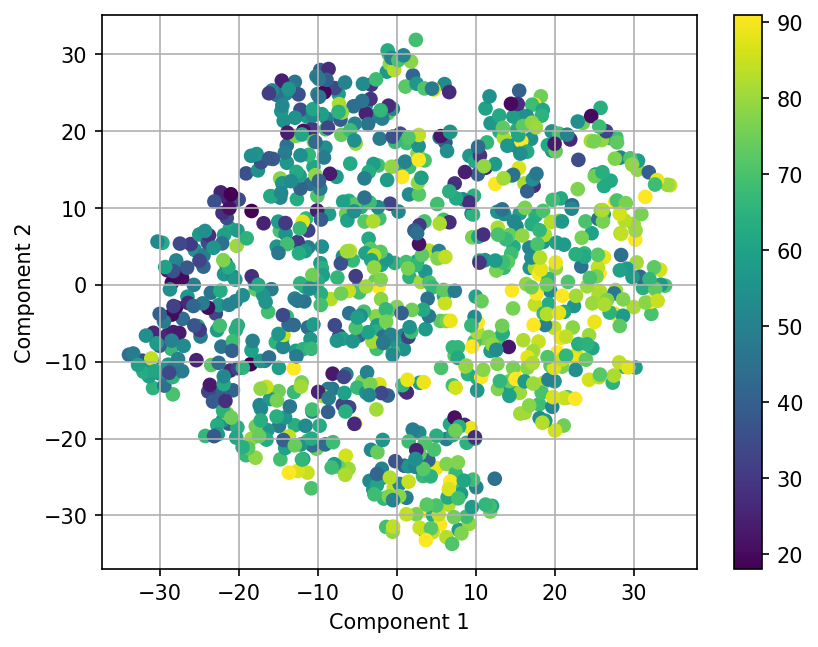

In [22]:
from sklearn.manifold import TSNE

# Load the data
# Create a t-SNE model
tsne = TSNE(n_components=2, perplexity=35,verbose=True,n_iter=2000)
# Fit the model to the data
tsne_X = tsne.fit_transform(xx)
# Plot the data
plt.figure(dpi=150)
plt.scatter(tsne_X[:, 0], tsne_X[:, 1], c=y_train[::inc])
plt.colorbar()
plt.grid(which='both')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
np.save('/content/gdrive/MyDrive/radiomics/TSNE_mimic_AGE.npy',{'comp':tsne_X,'c':y_train[::inc]})